<a href="https://colab.research.google.com/github/RyanGarciaLI/AILearn/blob/main/Chemprop_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run chemprop demo for both training and prediction.
chemprop repo: https://github.com/chemprop/chemprop

Author: LI YUXIN \
Modified: 11/11/2022

#Dependencies Installation

In [ ]:
!pip install chemprop
!pip install rdkit
!git clone https://github.com/chemprop/chemprop.git # for data download only
%cd chemprop
!tar xvzf data.tar.gz
!pip install git+https://github.com/bp-kelley/descriptastorus

#Input Data

The input for these models is a string representation of the molecule, also known as a `SMILES` string, standing for Simplified Molecular-Input Line-Entry System, e.g. `O=Cc1ccc(O)c(OC)c1`. The dataset in `/data` consists of molecules represented by SMILES strings and properties in binary numbers, e.g. whether it passes toxicity test or not.

Chemprop uses RDKit to featurize molecules data and exports a feature vector for each molecule containing its `atom_features` and `bond_feature`.


I will use `/data/clintox.csv` for following experiments. Firstly, I will split the whole dataset into a training dataset(80%) and a test dataset(20%).

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('data/clintox.csv')
data = df.iloc[:,:]
train, test = train_test_split(data, test_size=0.2)
train.to_csv('data/clintox_train.csv', index=False)
test.to_csv('data/clintox_test.csv',index=False)


#Step1: Tune the hyperparameters

Chemprop has a few tunable hyperparameters that can be adjusted to get the best possible results on a given dataset. In the paper, authors mention that their run 20 epochs for [Bayesian hyperparameters optimization]((https://papers.nips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)). Here I run 50 iterations. And I get the following hyperparameters.
<code>
  {
      "depth": 3,
      "dropout": 0.1,
      "ffn_hidden_size": 1500,
      "ffn_num_layers": 3,
      "hidden_size": 1500
  }
</code>

In [14]:
!chemprop_hyperopt \
    --data_path /content/chemprop/data/clintox_train.csv \
    --dataset_type classification \
    --num_iters 50 \
    --features_generator rdkit_2d_normalized --no_features_scaling \
    --config_save_path /content/chemprop/data/config.json

Streaming output truncated to the last 5000 lines.

 88%|########7 | 21/24 [00:02<00:00,  9.63it/s]

 92%|#########1| 22/24 [00:02<00:00,  9.39it/s]

 96%|#########5| 23/24 [00:02<00:00,  9.37it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

 67%|######6   | 2/3 [00:00<00:00, 15.51it/s]


Validation auc = 0.906214

 90%|######### | 27/30 [01:19<00:08,  2.85s/it]

Epoch 27

  0%|          | 0/24 [00:00<?, ?it/s]

Loss = 3.7331e-02, PNorm = 92.3675, GNorm = 0.2316, lr_0 = 1.1496e-04

  8%|8         | 2/24 [00:00<00:02,  8.34it/s]

 17%|#6        | 4/24 [00:00<00:02,  9.81it/s]

 25%|##5       | 6/24 [00:00<00:01,  9.44it/s]

 29%|##9       | 7/24 [00:00<00:01,  9.26it/s]

 33%|###3      | 8/24 [00:00<00:01,  9.19it/s]

 38%|###7      | 9/24 [00:00<00:01,  9.26it/s]

 42%|####1     | 10/24 [00:01<00:01,  9.36it/s]

 46%|####5     | 11/24 [00:01<00:01,  9.51it/s]

Loss = 2.7908e-02, PNorm = 92.3806, GNorm = 0.2077, lr_0 = 1.1093e-04

 50%|#####     | 12/24 [00:01<00:01,  7.83it/s]

 58%|#####

#Step2: Train the model

With the ideal hyperparameters identified and saved in `data/config.json`, we can then train a model with these parameters:

In [19]:
!chemprop_train \
    --data_path data/clintox_train.csv \
    --config_path data/config.json \
    --dataset_type classification \
    --save_dir model_checkpoint \
    --num_folds 5 \
    --ensemble_size 3 \
    --features_generator rdkit_2d_normalized --no_features_scaling \
    --split_type scaffold_balanced

Streaming output truncated to the last 5000 lines.
  0% 0/3 [00:00<?, ?it/s]
                         Validation auc = 0.899371
 53% 16/30 [00:16<00:13,  1.01it/s]Epoch 16

  0% 0/19 [00:00<?, ?it/s]
 16% 3/19 [00:00<00:00, 26.03it/s]
 32% 6/19 [00:00<00:00, 23.37it/s]Loss = 6.1477e-02, PNorm = 83.2098, GNorm = 0.2474, lr_0 = 2.8210e-04

 47% 9/19 [00:00<00:00, 22.48it/s]
 63% 12/19 [00:00<00:00, 23.08it/s]
 79% 15/19 [00:00<00:00, 23.39it/s]Loss = 6.9548e-02, PNorm = 83.2477, GNorm = 0.4097, lr_0 = 2.6950e-04

 95% 18/19 [00:00<00:00, 21.39it/s]
                                   
  0% 0/3 [00:00<?, ?it/s]
                         Validation auc = 0.900550
 57% 17/30 [00:17<00:12,  1.03it/s]Epoch 17

  0% 0/19 [00:00<?, ?it/s]
 16% 3/19 [00:00<00:00, 24.96it/s]
 32% 6/19 [00:00<00:00, 23.74it/s]Loss = 4.9032e-02, PNorm = 83.2894, GNorm = 0.6689, lr_0 = 2.5746e-04

 47% 9/19 [00:00<00:00, 21.69it/s]
 63% 12/19 [00:00<00:00, 22.70it/s]
 79% 15/19 [00:00<00:00, 22.65it/s]
 95% 18/19 [00:

A few interesting parameters of note here:

* `num_folds` create 5 folds (different train/test) splits and train/evaluate the model on each of these folds.
* `ensemble_size`  create an ensemble of 3 models with different initialization, which will improve mean performance. Note that each of these 3 models has 5 folds, so in total, the model are trained 15 times. The web demo provided by authors contains an ensemble of 20 trained antibiotics models, which is much more than mine.
* `split_type` When creating our internal train/test splits, it ensures that similar molecules are put into the same folds to get a more realistic measure of generalization.

On my training run, I received the following output: `Overall test auc = 0.841651 +/- 0.046645` — i.e., quite promising results from the training cross-validation.

#Step3: Evaluate the Model on new Data

From the previous cross-validation, we know that the performance should be around AUC of 0.84



In [20]:
!chemprop_predict \
    --test_path data/clintox_test.csv \
    --checkpoint_dir model_checkpoint \
    --features_generator rdkit_2d_normalized --no_features_scaling \
    --preds_path data/predictions.csv

Loading training args
Setting molecule featurization parameters to default.
Loading data
296it [00:00, 252084.06it/s]
100% 296/296 [00:13<00:00, 21.86it/s]
Validating SMILES
Test size = 296
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0% 0/15 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretraine

This will generate a file `predictions.csv` with predictions for the compounds in our test dataset. Note these predictions are the mean of a total of 15 models trained in the previous step. Then take toxcity test as our regression model. Holding prediciton values up against the true values, we get the following:

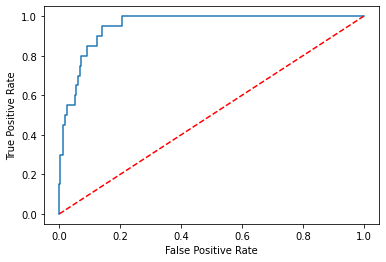

In [29]:
from sklearn import metrics
import matplotlib.pyplot as plt

test = pd.read_csv('data/clintox_test.csv')
predict = pd.read_csv('data/predictions.csv')
y_test = test.iloc[:, -1]
y_predict = predict.iloc[:, -1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predict)

#create ROC curve for toxcity test
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
